In [1]:
import numpy as np
import pandas as pd
import networkx as nx

In [2]:
from itertools import combinations, permutations
import sys
import pygraphviz as pvg
import matplotlib.pyplot as plt
from scoring_ilp import (DiscreteData,BDeu)
import networkx as nx
import pandas as pd
import numpy as np


In [3]:
from gurobipy import Model, GRB, quicksum

In [4]:
#from scoring_ilp_prunning import DiscreteData, BDeu
from scoring_ilp import DiscreteData, BDeu

In [5]:
# Class for Graphs
class ILPGraph:
    """ Wrapper class for graph instances and variables of a related integer linear program
    """

    def set_nx_graph(self, G):
        """ Set the underlying NetworkX graph

        :param G: a `NetworkX graph <https://networkx.org/documentation/stable/reference/introduction.html#graphs>`__
        """
        self.G = G

    def set_edge_vars(self, variables):
        """ Set the dictionary of edge variables

        :param variables: a dictionary with variable names as keys and gurobipy variables as values
        """
        self.edge_variables = variables

    def set_node_vars(self, variables):
        """ Set the dictionary of node variables

        :param variables: a dictionary with variable names as keys and gurobipy variables as values
        """
        self.node_variables = variables

    def set_label_vars(self, variables):
        """ Set the dictionary of node label variables

        :param variables: a dictionary with variable names as keys and gurobipy variables as values
        """
        self.label_variables = variables
    
    #New variable to add labels into the edges
    def set_label_edges(self, variables):
        """ Set the dictionary of edges label variables

        :param variables: a dictionary with edges names as keys and gurobipy variables as values
        """
        self.label_edges = variables
        

# Ground Truth

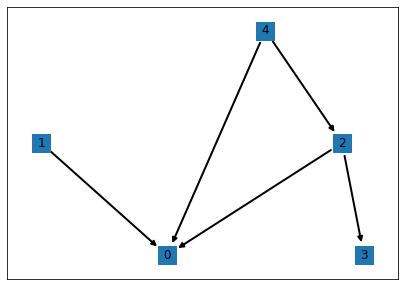

In [6]:
#plotting the ground truth graph
#adj_no_feasible.pkl
adj = pd.read_pickle('adj.pkl')
D = nx.DiGraph(adj, directed=True)
pos = nx.drawing.nx_agraph.graphviz_layout(D, prog='dot')
options = {
    'node_size': 350,
    'node_shape': 's',
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 10,
}
plt.figure(num=None,  figsize=(7, 5))
nx.draw_networkx(D, pos, arrows=True, vmin=0, vmax= .5,  cmap=plt.cm.get_cmap('RdBu_r'), **options)
plt.show()

## Creating the scores

In [7]:
def make_scores(data,palim,pruning):
    datos = DiscreteData(data)
    score = BDeu(datos, alpha=1).bdeu_scores(palim=palim,pruning=pruning)
    return score

In [8]:
#If `pruning` delete those parent sets which have a subset with a better score
# palim : max number of parents that a node can have
scores = make_scores('exp_cris.dat',palim=3,pruning=True)


In [9]:
scores

{'0': {frozenset(): -1414.276339262884,
  frozenset({'1'}): -1369.5230848525825,
  frozenset({'4'}): -1381.4433150246186,
  frozenset({'1', '4'}): -1336.7528653668996},
 '1': {frozenset(): -3359.865301724989, frozenset({'0'}): -3315.1120473146875},
 '2': {frozenset(): -5969.896552824794,
  frozenset({'3'}): -4617.9810018416465,
  frozenset({'4'}): -5359.111691210594,
  frozenset({'3', '4'}): -4181.438556422174},
 '3': {frozenset(): -6579.861411975391,
  frozenset({'2'}): -5227.945860992244,
  frozenset({'4'}): -6413.288508509635},
 '4': {frozenset(): -3279.763215644416,
  frozenset({'0'}): -3246.9301914061507,
  frozenset({'2'}): -2668.978354030216,
  frozenset({'3'}): -3113.19031217866,
  frozenset({'0', '2'}): -2642.8130189180083,
  frozenset({'0', '3'}): -3085.0725957698887}}

In [10]:
bn_variables = DiscreteData('exp_cris.dat').variables()

## Building initial graph

In [11]:
G = nx.DiGraph()

In [12]:
#building the graph from the dictionary of parents to optimize

for child, parent_dict in list(scores.items()):
    for parent_set, score in list(parent_dict.items()):
        if parent_set == frozenset():
            continue
            #if int(child) != 0 :
                #G.add_weighted_edges_from([(0, int(child), score)])
        elif len(parent_set) > 1: 
            G.add_weighted_edges_from([(tuple([int(parent) for parent in parent_set]), int(child), score)])
        else:
            G.add_weighted_edges_from([([int(parent) for parent in parent_set][0], int(child), score)])
        


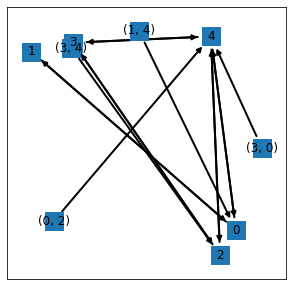

In [13]:
pos = nx.drawing.nx_agraph.graphviz_layout(D, prog='dot')
f = plt.figure(figsize=(5,5))
nx.draw_networkx(G,arrows=True, vmin=0, vmax= .5,  cmap=plt.cm.get_cmap('RdBu_r'), **options)

# ILP formulation

In [14]:
# Initiating model
m = Model()

Using license file /opt/gurobi/gurobi.lic


In [15]:
# Implementing the ILPGraph class 

ilpg = ILPGraph()
ilpg.set_nx_graph(G)

### Creating variables

In [16]:
ilpg.set_edge_vars(m.addVars(ilpg.G.edges(), vtype=GRB.BINARY))

In [17]:
nbr_nodes = ilpg.G.number_of_nodes()
nodes = list(ilpg.G.nodes())

In [18]:
# Add labels for nodes
label_vars = m.addVars(ilpg.G.nodes(), lb=0, ub=len(bn_variables)-1, vtype=GRB.INTEGER)
ilpg.set_label_vars(label_vars)


In [19]:
m.update()

In [20]:
edges = ilpg.edge_variables
initial_node = nodes[0]

### Creating constraints

In [21]:
# First Constraint
for node in ilpg.G.nodes():
    # Exactly one outgoing connection from every node
      m.addConstr(quicksum([edges[e] for e in ilpg.G.edges(node)]) == 1)

In [22]:
# #Create constraints with SUM
#m.addConstr(label_vars[initial_node] == 0)
for (u, v) in ilpg.G.edges():
    if (v != initial_node):
        m.addConstr(label_vars[u] >= label_vars[v] + edges[(u, v)]  -  len(bn_variables) * (1 - edges[(u, v)]))


### Setting objective to optimize 

In [23]:
direction=GRB.MAXIMIZE
m.setObjective(quicksum([edges[(u, v)] * w.get('weight', 1) for (u, v , w) in ilpg.G.edges(data=True)]), direction)
m.update()

In [24]:
m.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 22 rows, 23 columns and 53 nonzeros
Model fingerprint: 0xaffe5819
Variable types: 0 continuous, 23 integer (14 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+03, 6e+03]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective -24599.11484
Presolve removed 22 rows and 23 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: -23094.3 
No other solutions better than -23094.3

Optimal solution found (tolerance 1.00e-04)
Best objective -2.309432414988e+04, best bound -2.309432414988e+04, gap 0.0000%


In [25]:
# check status of te model
#-52486.8 
if m.status == GRB.OPTIMAL:   
    print('Optimal objective: %g' % m.objVal)
elif m.status == GRB.INF_OR_UNBD:    
    print('Model is infeasible or unbounded')    
elif m.status == GRB.INFEASIBLE:   
    print('Model is infeasible')    
elif m.status == GRB.UNBOUNDED:    
    print('Model is unbounded')    
else:  
    print('Optimization ended with status %d' % m.status)   
    
#-23026.1

Optimal objective: -23094.3


## Extracting results

In [26]:
edge_vars = ilpg.edge_variables
tour = [edge for edge, edge_var in edge_vars.items() if edge_var.X > 0.5]

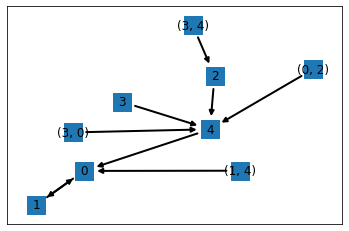

In [27]:
M = nx.DiGraph()
M.add_edges_from(tour)
nx.draw_networkx(M, arrows=True, vmin=0, vmax= .5,  cmap=plt.cm.get_cmap('RdBu_r'), **options)

In [28]:
def get_DAG(tour):
    new_dict = {}
    for pa, child in tour:
        if str(child) not in new_dict.keys():
            new_dict[str(child)] = {}
        if isinstance(pa, tuple):
            new_dict[str(child)][frozenset([str(p) for p in pa])] = scores[str(child)][frozenset([str(p) for p in pa])]
        else:
            new_dict[str(child)][frozenset({str(pa)})] = scores[str(child)][frozenset({str(pa)})]
    
    for child, parent_family in new_dict.items():
        parent_sets = list(parent_family.keys())
        for parent_set in parent_sets:
            if len(parent_set) >= 2:
                for parent in parent_set:
                    try:
                        if new_dict[child][frozenset({parent})] < new_dict[child][parent_set]:
                            new_dict[child][frozenset({parent})] = new_dict[child][parent_set]
                    except:
                        new_dict[child][frozenset({parent})] = new_dict[child][parent_set]
                del new_dict[child][parent_set]
            
    
    tuples = []
    score_values = []
    for child, parent_set in new_dict.items():
        for parent, score in parent_set.items():
            parent_int, *_ = parent
            tuples.append((int(child), int(parent_int)))
            score_values.append(score)

    for i, ti in enumerate(tuples):
        for j, tj in enumerate(tuples):
            if ti != tj:
                if sorted(ti) == sorted(tj):
                    try:
                        if score_values[i] >= score_values[j]:
                            del new_dict[str(tj[0])][frozenset(str(tj[1]))]
                        else:
                            del new_dict[str(ti[0])][frozenset(str(ti[1]))]
                    except KeyError:
                        continue
                        
    G = nx.DiGraph()
    for child, parent_dict in list(new_dict.items()):
        for parent_set, score in list(parent_dict.items()):
            if parent_set == frozenset():
                continue
                #if int(child) != 0 :
                    #G.add_weighted_edges_from([(0, int(child), score)])
            elif len(parent_set) > 1: 
                G.add_weighted_edges_from([(tuple([int(parent) for parent in parent_set]), int(child), score)])
            else:
                G.add_weighted_edges_from([([int(parent) for parent in parent_set][0], int(child), score)])
    return G

## Eliminate redundants

In [29]:
graph = get_DAG(tour)

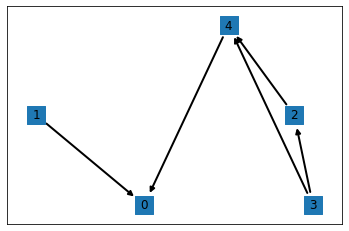

In [30]:
# ploting resulting graph, 
nx.draw_networkx(graph,pos, arrows=True, vmin=0, vmax= .5,  cmap=plt.cm.get_cmap('RdBu_r'), **options)

## With out the heuristic  extraction

In [31]:
#spliting the parent sets and dropping duplicates

tour_split = []
for i, j in tour:
    if isinstance(i, tuple):
        for i1 in range(len(i)):
            tour_split.append((i[i1], j))
    elif isinstance(j, tuple):
        for j1 in range(len(j)):
            tour_split.append((i, j[j1]))
    else:
        tour_split.append((i, j))
y = np.unique(tour_split, axis=0)
tour_new = [] 
for i in y:
    tour_new.append(tuple(i))

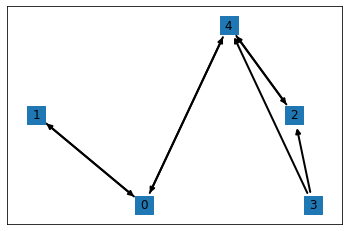

In [32]:
# Plotting CPDAG
M = nx.DiGraph()
M.add_edges_from(tour_new)
nx.draw_networkx(M,pos, arrows=True, vmin=0, vmax= .5,  cmap=plt.cm.get_cmap('RdBu_r'), **options)

In [33]:
from pcalg import topological_sort_grouped, diff_DAG, rec_directions, difference

## Metrics of the result vs the ground truth

In [34]:
(precision_pc, recall_pc, edges) = diff_DAG(D, M)
precision_dir_pc,recall_dir_pc = rec_directions(D, M)

In [35]:
print(precision_pc, recall_pc, edges)
print(precision_dir_pc,recall_dir_pc)

0.8 0.8 5
0.375 0.6


In [36]:
(precision_pc, recall_pc, edges) = diff_DAG(D, graph)
precision_dir_pc,recall_dir_pc = rec_directions(D, graph)

In [37]:
print(precision_pc, recall_pc, edges)
print(precision_dir_pc,recall_dir_pc)

0.8 0.8 5
0.4 0.4
